#Korean-English Seq2Seq Translator

##
1. **Config** - 하이퍼파라미터 설정
2. **Data** - 데이터 로드 및 전처리
3. **Model** - Seq2Seq with Attention
4. **Training** - 학습 함수
5. **Inference** - 추론 및 시각화
6. **Main** - 실행

In [130]:
#font
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

---
## 1. Config

In [107]:
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from dataclasses import dataclass
from typing import Tuple, List, Optional

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import sentencepiece as spm

try:
    rc('font', family='NanumBarunGothic')
except:
    pass
plt.rcParams['axes.unicode_minus'] = False

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [108]:
@dataclass
class Config:
    """하이퍼파라미터 설정"""
    # 경로
    data_dir: str = '/content/datasets'
    data_file: str = 'kor.txt'

    # 토크나이저
    vocab_size: int = 1000
    pad_id: int = 0
    bos_id: int = 1
    eos_id: int = 2
    unk_id: int = 3

    # 데이터
    max_len: int = 60
    batch_size: int = 64
    train_ratio: float = 0.8
    subword_alpha: float = 0.1

    # 모델
    emb_dim: int = 64
    hid_dim: int = 128
    dropout: float = 0.2
    bidirectional: bool = True

    # 학습
    epochs: int = 100
    lr: float = 1e-3
    weight_decay: float = 1e-4
    label_smoothing: float = 0.0
    clip_grad: float = 1.0
    patience: int = 5

    # Teacher Forcing
    tf_start: float = 0.9
    tf_end: float = 0.0
    tf_decay: float = 0.05  # epoch당 감소량

    # Device
    device: str = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

    @property
    def data_path(self) -> str:
        return os.path.join(self.data_dir, self.data_file)

cfg = Config()
print(f"Device: {cfg.device}")
print(f"Model: emb={cfg.emb_dim}, hid={cfg.hid_dim}, dropout={cfg.dropout}")

Device: cuda
Model: emb=64, hid=128, dropout=0.2


---
## 2. Data

In [109]:
#Data preprocessing f(x)
def preprocess_sentence(sentence: str, lang: str = 'eng') -> str:
    """문장 전처리"""
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    if lang == 'kor':
        sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,]+", " ", sentence)
    else:
        sentence = re.sub(r"[^a-zA-Z0-9?.!,']+", " ", sentence)

    return sentence.strip()


# def eda_augment(sentence: str, alpha: float = 0.15) -> str:
#     """EDA: 단어 swap/delete로 노이즈 추가"""
#     words = sentence.split()
#     n = len(words)
#     if n <= 2:
#         return sentence

#     # 단어 swap (30% 확률)
#     if random.random() < 0.3 and n > 1:
#         i, j = random.sample(range(n), 2)
#         words[i], words[j] = words[j], words[i]

#     # 단어 삭제 (20% 확률)
#     if random.random() < 0.2 and n > 3:
#         del_idx = random.randint(0, n - 1)
#         words.pop(del_idx)

#     return ' '.join(words)

In [110]:
#Data loading & Preprocessing
def load_data(cfg: Config) -> pd.DataFrame:
    """데이터 로드 및 전처리"""
    eng_corpus, kor_corpus = [], []

    with open(cfg.data_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split('\t')
            if len(parts) >= 2:
                eng_corpus.append(preprocess_sentence(parts[0], 'eng'))
                kor_corpus.append(preprocess_sentence(parts[1], 'kor'))

    # 코퍼스 저장 (SPM 학습용)
    with open('eng_corpus.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(eng_corpus))
    with open('kor_corpus.txt', 'w', encoding='utf-8') as f:
        f.write('\n'.join(kor_corpus))

    df = pd.DataFrame({'eng': eng_corpus, 'kor': kor_corpus})
    print(f"Loaded {len(df):,} sentence pairs")
    return df


def train_tokenizers(cfg: Config) -> Tuple[spm.SentencePieceProcessor, spm.SentencePieceProcessor]:
    """SentencePiece 토크나이저 학습"""
    for lang, prefix in [('eng', 'encoder'), ('kor', 'decoder')]:
        spm.SentencePieceTrainer.train(
            input=f"{lang}_corpus.txt",
            model_prefix=f"{prefix}_spm",
            vocab_size=cfg.vocab_size,
            pad_id=cfg.pad_id,
            bos_id=cfg.bos_id,
            eos_id=cfg.eos_id,
            unk_id=cfg.unk_id,
            model_type='unigram',
        )

    enc_tokenizer = spm.SentencePieceProcessor()
    enc_tokenizer.load("encoder_spm.model")

    dec_tokenizer = spm.SentencePieceProcessor()
    dec_tokenizer.load("decoder_spm.model")

    print(f"Tokenizers trained: vocab_size={cfg.vocab_size}")
    return enc_tokenizer, dec_tokenizer

In [111]:
class TranslationDataset(Dataset):
    def __init__(self, data: pd.DataFrame, enc_tokenizer, dec_tokenizer, cfg: Config, is_train: bool = True):
        self.data = data
        self.enc_tokenizer = enc_tokenizer
        self.dec_tokenizer = dec_tokenizer
        self.max_len = cfg.max_len
        self.pad_id = cfg.pad_id
        self.bos_id = cfg.bos_id
        self.eos_id = cfg.eos_id
        self.is_train = is_train  # ← 추가

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
      src_text = self.data.iloc[idx]['eng']
      trg_text = self.data.iloc[idx]['kor']

      # Encode with subword sampling (train만)
      if self.is_train:
          src_ids = self.enc_tokenizer.encode(
              src_text,
              enable_sampling=True,
              alpha=0.1,
              nbest_size=-1
          )[:self.max_len - 1] + [self.eos_id]

          trg_ids = self.dec_tokenizer.encode(
              trg_text,
              enable_sampling=True,
              alpha=0.1,
              nbest_size=-1
          )
      else:
          src_ids = self.enc_tokenizer.encode(src_text)[:self.max_len - 1] + [self.eos_id]
          trg_ids = self.dec_tokenizer.encode(trg_text)

      trg_input = [self.bos_id] + trg_ids[:self.max_len - 2] + [self.eos_id]
      trg_label = trg_ids[:self.max_len - 1] + [self.eos_id]

      # Padding
      src_ids += [self.pad_id] * (self.max_len - len(src_ids))
      trg_input += [self.pad_id] * (self.max_len - len(trg_input))
      trg_label += [self.pad_id] * (self.max_len - len(trg_label))

      return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_label)

In [112]:
#creating dataloader here

def create_dataloaders(
    df: pd.DataFrame,
    enc_tokenizer,
    dec_tokenizer,
    cfg: Config
) -> Tuple[DataLoader, DataLoader]:
    """Train/Valid DataLoader 생성"""

    train_df = df.sample(frac=cfg.train_ratio, random_state=42).copy()
    valid_df = df.drop(train_df.index).copy()
    train_df.reset_index(drop=True, inplace=True)
    valid_df.reset_index(drop=True, inplace=True)

    # EDA 부분 삭제하고 심플하게
    train_dataset = TranslationDataset(train_df, enc_tokenizer, dec_tokenizer, cfg, is_train=True)
    valid_dataset = TranslationDataset(valid_df, enc_tokenizer, dec_tokenizer, cfg, is_train=False)

    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=cfg.batch_size, shuffle=False)

    print(f"Train: {len(train_df)} samples (subword sampling enabled)")
    print(f"Valid: {len(valid_df)} samples")

    return train_loader, valid_loader

In [151]:
import numpy as np

path_to_file = "/content/datasets/kor.txt"

eng_lens, kor_lens = [], []

with open(path_to_file, 'r', encoding='utf-8') as f:
    for line in f:
        parts = line.split('\t')
        if len(parts) >= 2:
            eng_lens.append(len(parts[0].split()))
            kor_lens.append(len(parts[1].split()))

print("=== 영어 ===")
print(f"평균: {np.mean(eng_lens):.1f}")
print(f"중앙값: {np.median(eng_lens):.0f}")
print(f"최대: {max(eng_lens)}")
print(f"95%: {np.percentile(eng_lens, 95):.0f}")
print(f"99%: {np.percentile(eng_lens, 99):.0f}")

print("\n=== 한국어 ===")
print(f"평균: {np.mean(kor_lens):.1f}")
print(f"중앙값: {np.median(kor_lens):.0f}")
print(f"최대: {max(kor_lens)}")
print(f"95%: {np.percentile(kor_lens, 95):.0f}")
print(f"99%: {np.percentile(kor_lens, 99):.0f}")

print("\n=== max_len 커버리지 ===")
for m in [10, 15, 20, 25, 30, 40, 50, 60]:
    eng_cov = sum(1 for l in eng_lens if l <= m) / len(eng_lens) * 100
    kor_cov = sum(1 for l in kor_lens if l <= m) / len(kor_lens) * 100
    print(f"max_len={m}: 영어 {eng_cov:.1f}% | 한국어 {kor_cov:.1f}%")

=== 영어 ===
평균: 5.5
중앙값: 5
최대: 101
95%: 10
99%: 13

=== 한국어 ===
평균: 4.2
중앙값: 4
최대: 89
95%: 7
99%: 10

=== max_len 커버리지 ===
max_len=10: 영어 96.5% | 한국어 99.4%
max_len=15: 영어 99.7% | 한국어 99.9%
max_len=20: 영어 99.9% | 한국어 100.0%
max_len=25: 영어 99.9% | 한국어 100.0%
max_len=30: 영어 100.0% | 한국어 100.0%
max_len=40: 영어 100.0% | 한국어 100.0%
max_len=50: 영어 100.0% | 한국어 100.0%
max_len=60: 영어 100.0% | 한국어 100.0%


---
## 3. Model

In [113]:
#Attention
class BahdanauAttention(nn.Module):
    def __init__(self, hid_dim: int, bidirectional: bool = True):
        super().__init__()
        enc_dim = hid_dim * 2 if bidirectional else hid_dim
        self.W1 = nn.Linear(enc_dim, hid_dim)
        self.W2 = nn.Linear(hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden: torch.Tensor, encoder_outputs: torch.Tensor) -> torch.Tensor:
        # hidden: (batch, hid_dim)
        # encoder_outputs: (src_len, batch, enc_dim)
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention = self.v(energy).squeeze(2)

        return torch.softmax(attention, dim=1)

In [114]:
#Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim: int, emb_dim: int, hid_dim: int,
                 dropout: float = 0.5, bidirectional: bool = True):
        super().__init__()
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=bidirectional)

        if bidirectional:
            self.fc = nn.Linear(hid_dim * 2, hid_dim)

    def forward(self, src: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)

        if self.bidirectional:
            hidden = torch.tanh(self.fc(torch.cat((hidden[-2], hidden[-1]), dim=1)))
        else:
            hidden = hidden[-1]

        return outputs, hidden.unsqueeze(0)

In [115]:
#decoder
class Decoder(nn.Module):
    def __init__(self, output_dim: int, emb_dim: int, hid_dim: int,
                 attention: nn.Module, dropout: float = 0.5, bidirectional: bool = True):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention

        enc_dim = hid_dim * 2 if bidirectional else hid_dim

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.rnn = nn.GRU(emb_dim + enc_dim, hid_dim)

        # Bottleneck projection
        self.projection = nn.Linear(hid_dim + enc_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)

    def forward(self, input: torch.Tensor, hidden: torch.Tensor,
                encoder_outputs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))

        # Attention
        a = self.attention(hidden.squeeze(0), encoder_outputs)
        a = a.unsqueeze(1)
        encoder_outputs_t = encoder_outputs.permute(1, 0, 2)
        context = torch.bmm(a, encoder_outputs_t).permute(1, 0, 2)

        # RNN
        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)

        # Output projection
        output = output.squeeze(0)
        context = context.squeeze(0)
        projected = torch.tanh(self.projection(torch.cat((output, context), dim=1)))
        prediction = self.fc_out(projected)

        return prediction, hidden, a.squeeze(1)

In [116]:
#seq2seq
class Seq2Seq(nn.Module):
    def __init__(self, encoder: Encoder, decoder: Decoder, cfg: Config):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = cfg.device
        self.bos_id = cfg.bos_id
        self.eos_id = cfg.eos_id

    def forward(self, src: torch.Tensor, trg: Optional[torch.Tensor] = None,
                teacher_forcing_ratio: float = 0.5, max_len: int = 60
               ) -> Tuple[torch.Tensor, torch.Tensor]:

        batch_size = src.shape[1]
        encoder_outputs, hidden = self.encoder(src)

        outputs, attentions = [], []

        if trg is not None:
            # Training
            input = trg[0, :]
            for t in range(1, trg.shape[0]):
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

                teacher_force = random.random() < teacher_forcing_ratio
                input = trg[t] if teacher_force else output.argmax(1)
        else:
            # Inference
            input = torch.full((batch_size,), self.bos_id, dtype=torch.long, device=self.device)
            finished = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

            for t in range(max_len):
                output, hidden, attention = self.decoder(input, hidden, encoder_outputs)
                outputs.append(output.unsqueeze(0))
                attentions.append(attention.unsqueeze(0))

                input = output.argmax(1)
                finished |= (input == self.eos_id)
                if finished.all():
                    break

        outputs = torch.cat(outputs, dim=0)
        attentions = torch.cat(attentions, dim=0)

        return outputs, attentions

In [117]:
#model instantiation f(x)
def create_model(input_dim: int, output_dim: int, cfg: Config) -> Seq2Seq:
    """모델 생성"""
    encoder = Encoder(
        input_dim, cfg.emb_dim, cfg.hid_dim,
        cfg.dropout, cfg.bidirectional
    )

    attention = BahdanauAttention(cfg.hid_dim, cfg.bidirectional)

    decoder = Decoder(
        output_dim, cfg.emb_dim, cfg.hid_dim,
        attention, cfg.dropout, cfg.bidirectional
    )

    model = Seq2Seq(encoder, decoder, cfg).to(cfg.device)

    # 파라미터 수 출력
    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model created: {total:,} trainable parameters")

    return model

---
## 4. Training

In [118]:
#Train epoch & Eval
def train_epoch(model: Seq2Seq, loader: DataLoader, optimizer: optim.Optimizer,
                criterion: nn.Module, cfg: Config, tf_ratio: float) -> float:
    """1 에폭 학습"""
    model.train()
    total_loss = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for src, trg_input, trg_label in pbar:
        src = src.transpose(0, 1).to(cfg.device)
        trg_input = trg_input.transpose(0, 1).to(cfg.device)
        trg_label = trg_label.transpose(0, 1).to(cfg.device)

        optimizer.zero_grad()
        outputs, _ = model(src, trg_input, teacher_forcing_ratio=tf_ratio)

        # Loss 계산 (첫 토큰 제외)
        outputs = outputs.view(-1, outputs.shape[-1])
        trg_label = trg_label[:-1].reshape(-1)

        loss = criterion(outputs, trg_label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.clip_grad)
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.3f}")

    return total_loss / len(loader)


def evaluate(model: Seq2Seq, loader: DataLoader, criterion: nn.Module, cfg: Config) -> float:
    """검증"""
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, trg_input, trg_label in loader:
            src = src.transpose(0, 1).to(cfg.device)
            trg_input = trg_input.transpose(0, 1).to(cfg.device)
            trg_label = trg_label.transpose(0, 1).to(cfg.device)

            outputs, _ = model(src, trg_input, teacher_forcing_ratio=0.0)

            outputs = outputs.view(-1, outputs.shape[-1])
            trg_label = trg_label[:-1].reshape(-1)

            loss = criterion(outputs, trg_label)
            total_loss += loss.item()

    return total_loss / len(loader)

In [119]:
#Early Stopping
class EarlyStopping:
    def __init__(self, patience: int = 5, path: str = 'best_model.pt'):
        self.patience = patience
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss: float, model: nn.Module) -> bool:
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            return True  # improved
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False  # not improved

In [120]:
#training loop
def train(model: Seq2Seq, train_loader: DataLoader, valid_loader: DataLoader,
          cfg: Config) -> List[dict]:

    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    criterion = nn.CrossEntropyLoss(ignore_index=cfg.pad_id, label_smoothing=cfg.label_smoothing)
    early_stopping = EarlyStopping(patience=cfg.patience)

    history = []

    for epoch in range(cfg.epochs):
        # Teacher forcing decay
        tf_ratio = max(cfg.tf_end, cfg.tf_start - epoch * cfg.tf_decay)

        train_loss = train_epoch(model, train_loader, optimizer, criterion, cfg, tf_ratio)
        valid_loss = evaluate(model, valid_loader, criterion, cfg)

        improved = early_stopping(valid_loss, model)
        status = "saved" if improved else f"({early_stopping.counter}/{cfg.patience})"

        print(f"Epoch {epoch+1:2d} | TF={tf_ratio:.2f} | "
              f"Train={train_loss:.4f} | Val={valid_loss:.4f} {status}")

        history.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'tf_ratio': tf_ratio
        })

        if early_stopping.early_stop:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

    # load best model
    model.load_state_dict(torch.load(early_stopping.path))
    print(f"\nBest model loaded (val_loss={early_stopping.best_loss:.4f})")

    return history

---
## 5. Inference

In [121]:
#translation f(x)
def translate_sentence(sentence: str, model: Seq2Seq, enc_tokenizer, dec_tokenizer,
                       cfg: Config, max_len: int = 60) -> Tuple[str, np.ndarray]:
    """문장 번역"""
    model.eval()

    # 전처리 및 인코딩
    sentence = preprocess_sentence(sentence, 'eng')
    src_ids = enc_tokenizer.encode(sentence)[:max_len]
    src_ids += [cfg.pad_id] * (max_len - len(src_ids))
    src_tensor = torch.tensor(src_ids).unsqueeze(1).to(cfg.device)

    with torch.no_grad():
        outputs, attentions = model(src_tensor, max_len=max_len)

    # 디코딩
    pred_ids = outputs.argmax(2).squeeze(1).cpu().tolist()

    # EOS까지만
    if cfg.eos_id in pred_ids:
        pred_ids = pred_ids[:pred_ids.index(cfg.eos_id)]

    result = dec_tokenizer.decode(pred_ids)
    attention = attentions.squeeze(1).cpu().numpy()

    return result, attention


def translate(sentence: str, model: Seq2Seq, enc_tokenizer, dec_tokenizer,
              cfg: Config, show_attention: bool = True):
    """번역 및 출력"""
    result, attention = translate_sentence(sentence, model, enc_tokenizer, dec_tokenizer, cfg)

    print(f"Input:  {sentence}")
    print(f"Output: {result}")

    if show_attention:
        plot_attention(sentence, result, attention, enc_tokenizer, dec_tokenizer)

In [122]:
#attention visualization f(x)
def plot_attention(src_sentence: str, trg_sentence: str, attention: np.ndarray,
                   enc_tokenizer, dec_tokenizer):
    """Attention 히트맵"""
    src_tokens = enc_tokenizer.encode_as_pieces(preprocess_sentence(src_sentence, 'eng'))
    trg_tokens = dec_tokenizer.encode_as_pieces(trg_sentence)

    # Attention 크기 조정
    attn = attention[:len(trg_tokens), :len(src_tokens)]

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.matshow(attn, cmap='Blues')

    ax.set_xticks(range(len(src_tokens)))
    ax.set_xticklabels(src_tokens, rotation=45, ha='left')
    ax.set_yticks(range(len(trg_tokens)))
    ax.set_yticklabels(trg_tokens)

    ax.set_xlabel('Source')
    ax.set_ylabel('Target')

    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

In [123]:
#learning curve visualization f(x)
def plot_history(history: List[dict]):
    """학습 곡선"""
    epochs = [h['epoch'] for h in history]
    train_loss = [h['train_loss'] for h in history]
    valid_loss = [h['valid_loss'] for h in history]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(epochs, train_loss, 'b-', label='Train')
    ax.plot(epochs, valid_loss, 'r-', label='Valid')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training History')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

---
## 6. Main - 실행

In [124]:
df = load_data(cfg)
enc_tokenizer, dec_tokenizer = train_tokenizers(cfg)
train_loader, valid_loader = create_dataloaders(df, enc_tokenizer, dec_tokenizer, cfg)

Loaded 6,381 sentence pairs
Tokenizers trained: vocab_size=1000
Train: 5105 samples (subword sampling enabled)
Valid: 1276 samples


In [125]:
#model instantiation
input_dim = len(enc_tokenizer)
output_dim = len(dec_tokenizer)

model = create_model(input_dim, output_dim, cfg)
print(model)

Model created: 710,504 trainable parameters
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1000, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): GRU(64, 128, bidirectional=True)
    (fc): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (attention): BahdanauAttention(
      (W1): Linear(in_features=256, out_features=128, bias=True)
      (W2): Linear(in_features=128, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
    (embedding): Embedding(1000, 64)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): GRU(320, 128)
    (projection): Linear(in_features=384, out_features=128, bias=True)
    (fc_out): Linear(in_features=128, out_features=1000, bias=True)
  )
)


In [126]:
#train
history = train(model, train_loader, valid_loader, cfg)

Epoch  1 | TF=0.90 | Train=4.5638 | Val=4.5328 saved


Epoch  2 | TF=0.85 | Train=4.0344 | Val=4.5959 (1/5)


Epoch  3 | TF=0.80 | Train=3.8366 | Val=4.6198 (2/5)


Epoch  4 | TF=0.75 | Train=3.7423 | Val=4.5200 saved


Epoch  5 | TF=0.70 | Train=3.6693 | Val=4.3881 saved


Epoch  6 | TF=0.65 | Train=3.6404 | Val=4.4184 (1/5)


Epoch  7 | TF=0.60 | Train=3.6559 | Val=4.2211 saved


Epoch  8 | TF=0.55 | Train=3.6165 | Val=4.1789 saved


Epoch  9 | TF=0.50 | Train=3.6067 | Val=4.1021 saved


Epoch 10 | TF=0.45 | Train=3.6088 | Val=4.0743 saved


Epoch 11 | TF=0.40 | Train=3.6286 | Val=4.0476 saved


Epoch 12 | TF=0.35 | Train=3.6262 | Val=4.0230 saved


Epoch 13 | TF=0.30 | Train=3.6678 | Val=4.0031 saved


Epoch 14 | TF=0.25 | Train=3.6801 | Val=4.0316 (1/5)


Epoch 15 | TF=0.20 | Train=3.7101 | Val=3.9669 saved


Epoch 16 | TF=0.15 | Train=3.7418 | Val=3.9488 saved


Epoch 17 | TF=0.10 | Train=3.7809 | Val=3.9136 saved


Epoch 18 | TF=0.05 | Train=3.8022 | Val=3.9012 saved


Epoch 19 | TF=0.00 | Train=3.8427 | Val=3.8864 saved


Epoch 20 | TF=0.00 | Train=3.8289 | Val=3.8849 saved


Epoch 21 | TF=0.00 | Train=3.8077 | Val=3.8674 saved


Epoch 22 | TF=0.00 | Train=3.7961 | Val=3.8691 (1/5)


Epoch 23 | TF=0.00 | Train=3.7882 | Val=3.8697 (2/5)


Epoch 24 | TF=0.00 | Train=3.7784 | Val=3.8440 saved


Epoch 25 | TF=0.00 | Train=3.7643 | Val=3.8306 saved


Epoch 26 | TF=0.00 | Train=3.7538 | Val=3.8276 saved


Epoch 27 | TF=0.00 | Train=3.7437 | Val=3.8168 saved


Epoch 28 | TF=0.00 | Train=3.7360 | Val=3.8190 (1/5)


Epoch 29 | TF=0.00 | Train=3.7244 | Val=3.8342 (2/5)


Epoch 30 | TF=0.00 | Train=3.7185 | Val=3.8085 saved


Epoch 31 | TF=0.00 | Train=3.7081 | Val=3.8042 saved


Epoch 32 | TF=0.00 | Train=3.6963 | Val=3.8042 saved


Epoch 33 | TF=0.00 | Train=3.6908 | Val=3.7860 saved


Epoch 34 | TF=0.00 | Train=3.6804 | Val=3.7985 (1/5)


Epoch 35 | TF=0.00 | Train=3.6759 | Val=3.7905 (2/5)


Epoch 36 | TF=0.00 | Train=3.6602 | Val=3.7668 saved


Epoch 37 | TF=0.00 | Train=3.6597 | Val=3.7613 saved


Epoch 38 | TF=0.00 | Train=3.6458 | Val=3.7520 saved


Epoch 39 | TF=0.00 | Train=3.6360 | Val=3.7554 (1/5)


Epoch 40 | TF=0.00 | Train=3.6303 | Val=3.7477 saved


Epoch 41 | TF=0.00 | Train=3.6176 | Val=3.7547 (1/5)


Epoch 42 | TF=0.00 | Train=3.6090 | Val=3.7287 saved


Epoch 43 | TF=0.00 | Train=3.6021 | Val=3.7277 saved


Epoch 44 | TF=0.00 | Train=3.5891 | Val=3.7261 saved


Epoch 45 | TF=0.00 | Train=3.5871 | Val=3.7196 saved


Epoch 46 | TF=0.00 | Train=3.5831 | Val=3.7152 saved


Epoch 47 | TF=0.00 | Train=3.5704 | Val=3.7112 saved


Epoch 48 | TF=0.00 | Train=3.5654 | Val=3.7090 saved


Epoch 49 | TF=0.00 | Train=3.5544 | Val=3.7001 saved


Epoch 50 | TF=0.00 | Train=3.5473 | Val=3.6917 saved


Epoch 51 | TF=0.00 | Train=3.5379 | Val=3.6923 (1/5)


Epoch 52 | TF=0.00 | Train=3.5261 | Val=3.6867 saved


Epoch 53 | TF=0.00 | Train=3.5221 | Val=3.6684 saved


Epoch 54 | TF=0.00 | Train=3.5202 | Val=3.6688 (1/5)


Epoch 55 | TF=0.00 | Train=3.5081 | Val=3.6630 saved


Epoch 56 | TF=0.00 | Train=3.4952 | Val=3.6675 (1/5)


Epoch 57 | TF=0.00 | Train=3.4860 | Val=3.6559 saved


Epoch 58 | TF=0.00 | Train=3.4802 | Val=3.6537 saved


Epoch 59 | TF=0.00 | Train=3.4730 | Val=3.6498 saved


Epoch 60 | TF=0.00 | Train=3.4630 | Val=3.6405 saved


Epoch 61 | TF=0.00 | Train=3.4580 | Val=3.6441 (1/5)


Epoch 62 | TF=0.00 | Train=3.4491 | Val=3.6392 saved


Epoch 63 | TF=0.00 | Train=3.4453 | Val=3.6433 (1/5)


Epoch 64 | TF=0.00 | Train=3.4325 | Val=3.6183 saved


Epoch 65 | TF=0.00 | Train=3.4251 | Val=3.6165 saved


Epoch 66 | TF=0.00 | Train=3.4161 | Val=3.6128 saved


Epoch 67 | TF=0.00 | Train=3.4077 | Val=3.6118 saved


Epoch 68 | TF=0.00 | Train=3.4021 | Val=3.6009 saved


Epoch 69 | TF=0.00 | Train=3.3942 | Val=3.5928 saved


Epoch 70 | TF=0.00 | Train=3.3891 | Val=3.5906 saved


Epoch 71 | TF=0.00 | Train=3.3809 | Val=3.5933 (1/5)


Epoch 72 | TF=0.00 | Train=3.3693 | Val=3.5860 saved


Epoch 73 | TF=0.00 | Train=3.3663 | Val=3.5819 saved


Epoch 74 | TF=0.00 | Train=3.3571 | Val=3.6009 (1/5)


Epoch 75 | TF=0.00 | Train=3.3503 | Val=3.5810 saved


Epoch 76 | TF=0.00 | Train=3.3400 | Val=3.5794 saved


Epoch 77 | TF=0.00 | Train=3.3270 | Val=3.5632 saved


Epoch 78 | TF=0.00 | Train=3.3264 | Val=3.5560 saved


Epoch 79 | TF=0.00 | Train=3.3212 | Val=3.5577 (1/5)


Epoch 80 | TF=0.00 | Train=3.3063 | Val=3.5602 (2/5)


Epoch 81 | TF=0.00 | Train=3.3000 | Val=3.5582 (3/5)


Epoch 82 | TF=0.00 | Train=3.2953 | Val=3.5545 saved


Epoch 83 | TF=0.00 | Train=3.2810 | Val=3.5591 (1/5)


Epoch 84 | TF=0.00 | Train=3.2825 | Val=3.5474 saved


Epoch 85 | TF=0.00 | Train=3.2685 | Val=3.5492 (1/5)


Epoch 86 | TF=0.00 | Train=3.2685 | Val=3.5453 saved


Epoch 87 | TF=0.00 | Train=3.2568 | Val=3.5464 (1/5)


Epoch 88 | TF=0.00 | Train=3.2553 | Val=3.5385 saved


Epoch 89 | TF=0.00 | Train=3.2468 | Val=3.5465 (1/5)


Epoch 90 | TF=0.00 | Train=3.2433 | Val=3.5261 saved


Epoch 91 | TF=0.00 | Train=3.2318 | Val=3.5259 saved


Epoch 92 | TF=0.00 | Train=3.2240 | Val=3.5406 (1/5)


Epoch 93 | TF=0.00 | Train=3.2195 | Val=3.5197 saved


Epoch 94 | TF=0.00 | Train=3.2111 | Val=3.5320 (1/5)


Epoch 95 | TF=0.00 | Train=3.2071 | Val=3.5241 (2/5)


Epoch 96 | TF=0.00 | Train=3.1939 | Val=3.5187 saved


Epoch 97 | TF=0.00 | Train=3.1932 | Val=3.5134 saved


Epoch 98 | TF=0.00 | Train=3.1851 | Val=3.5090 saved


Epoch 99 | TF=0.00 | Train=3.1760 | Val=3.5125 (1/5)


Epoch 100 | TF=0.00 | Train=3.1680 | Val=3.5165 (2/5)

Best model loaded (val_loss=3.5090)


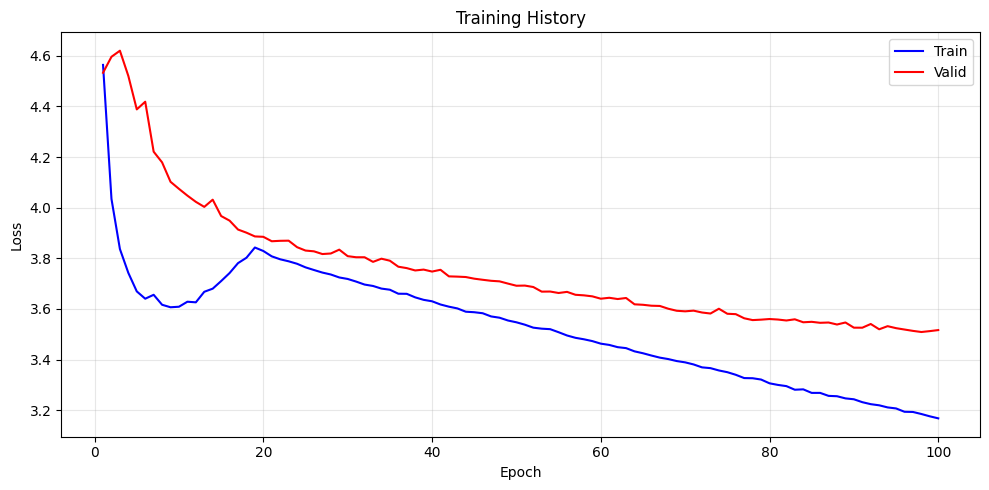

In [127]:
#learning curve
plot_history(history)

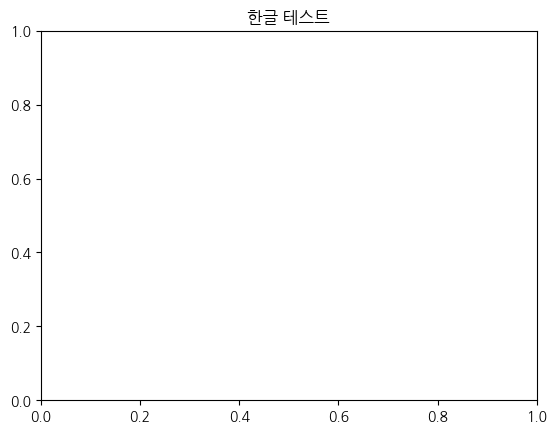

In [152]:
# 폰트 설정 (이거 하나로 끝)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔폰트 경로 직접 지정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 테스트
plt.figure()
plt.title('한글 테스트')
plt.show()

In [226]:
# ============================================================
# 6.5 테스트
# ============================================================

test_sentences = ["Sorry?", "Attack!", "How many eggs did you buy?", "She smiled."
 ,  "I'm taking a French class.", "That's a real good sign."]
for sent in test_sentences:
    print("=" * 50)
    translate(sent, model, enc_tokenizer, dec_tokenizer, cfg, show_attention=False)

Input:  Sorry?
Output: 무 해 ?
Input:  Attack!
Output: 공  !
Input:  How many eggs did you buy?
Output: 얼마          ??
Input:  She smiled.
Output: 그는는 웃   .
Input:  I'm taking a French class.
Output: 는는 프랑스어스   고  .
Input:  That's a real good sign.
Output: 이건 정말  좋    


Input:  She smiled.
Output: 그는는 웃   .


/tmp/ipython-input-2446374474.py:23: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


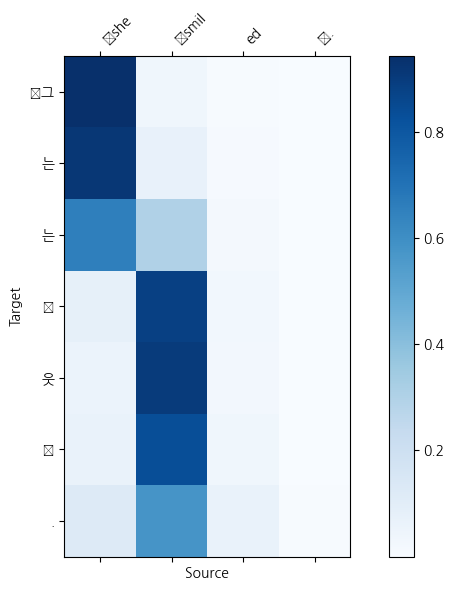

Input:  That's a real good sign.
Output: 이건 정말  좋    


/tmp/ipython-input-2446374474.py:23: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


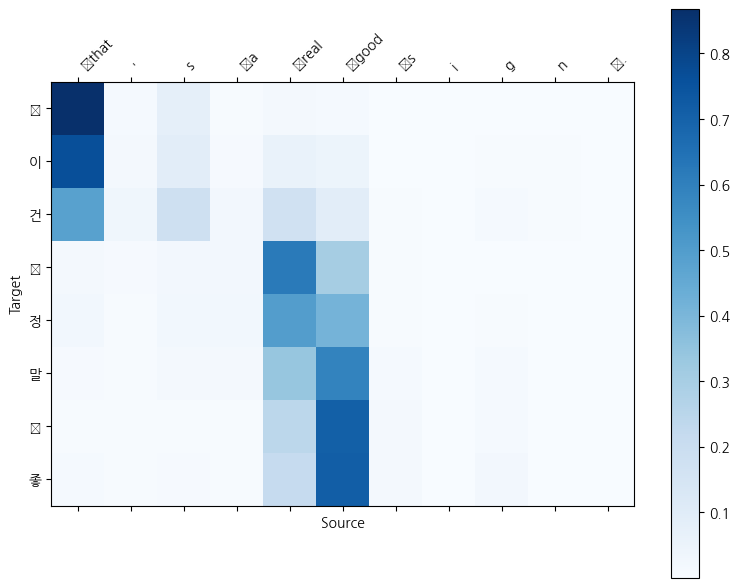

Input:  I'm taking a French class.
Output: 는는 프랑스어스   고  .


/tmp/ipython-input-2446374474.py:23: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


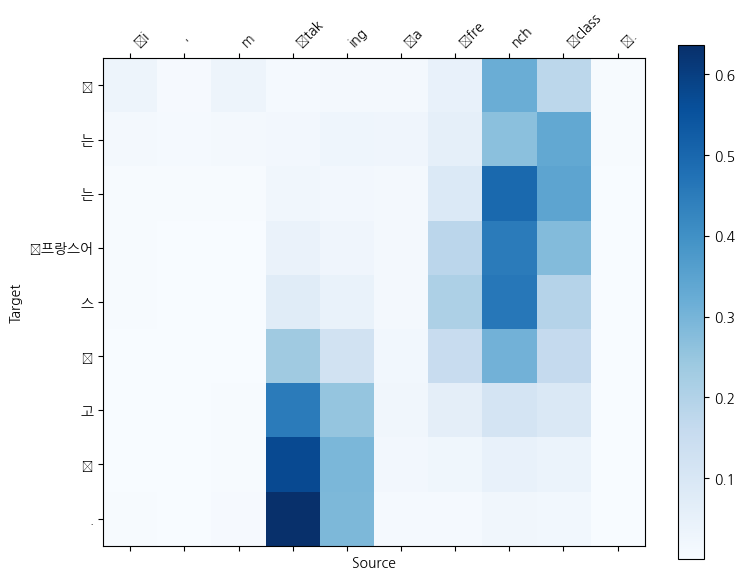

In [227]:
#attention map
translate("She smiled.", model, enc_tokenizer, dec_tokenizer, cfg, show_attention=True)
translate("That's a real good sign.", model, enc_tokenizer, dec_tokenizer, cfg, show_attention=True)
translate("I'm taking a French class.", model, enc_tokenizer, dec_tokenizer, cfg, show_attention=True)


회고

eda 추가로는 딱히 별다른 성능개선을 보이진 않음
역번역 추가시 유의미한 차이를 걸리지만 너무 오래걸림
subword sampling을 진행, 성능적으로 더 나은 모습을 보임
결론적으로 데이터가 적을수록 양질의 데이터를 추가해야 하는듯함

또한 기본적으로 데이터가 너무 적기에 어텐션 기반 모델을 돌리는건 무리 수
최대한 패러미터를 줄이면서 돌리면 그나마 과적합 없이 val loss가 3.5 정도까지 내려가는 모습을 관찰
트랜스포머 프로젝트 노드는 데이터수가 만 단위던데 그냥 이 노드도 그걸 쓰면 안됬던걸까라는 생각이 든다.

차라리 attention 없는 seq2seq가 더 결과가 잘 나올꺼 같다는 생각이 진행하는 내내 들었다. 대체적으로 문장 길이가 짧으니까 더더욱
